In [28]:
import sys, glob, itertools, time
import numpy as np
import qiskit

import networkx as nx
from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection

import utils.graph_funcs as graph_funcs
import utils.helper_funcs as helper_funcs
import utils.cutting_funcs as cutting_funcs

import qsplit_circuit_cutter as qcc
import qsplit_mlrecon_methods as qmm
import qsplit_dqva_methods as qdm

from ansatz import dqv_cut_ansatz
import dqva

from scipy.optimize import minimize

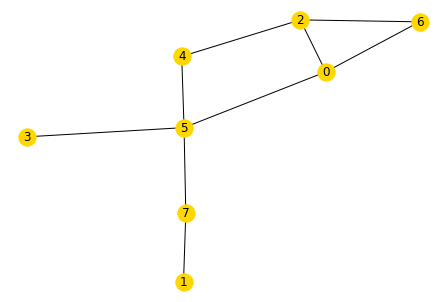

In [2]:
test_graphs = glob.glob("benchmark_graphs/N8_p30_graphs/*")
#test_graph = np.random.choice(test_graphs)
G = graph_funcs.graph_from_file(test_graphs[0])
qubit_num = G.number_of_nodes()
nx.draw_spring(G, with_labels=True, node_color='gold')

Partition: ({1, 3, 5, 7}, {0, 2, 4, 6})
Cut edges: [(5, 4), (0, 5)]
Cut nodes: [5, 4, 0, 5] Hot nodes: [0, 4]


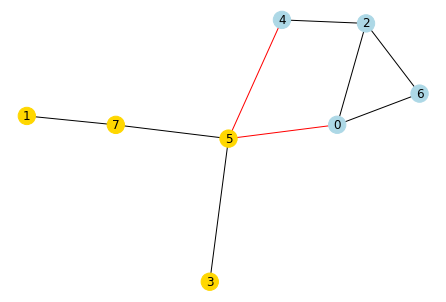

In [7]:
partition = kernighan_lin_bisection(G)
print('Partition:', partition)
subgraphs, cut_edges = graph_funcs.get_subgraphs(G, partition)
cut_nodes, hot_nodes = cutting_funcs.choose_nodes(G, subgraphs, cut_edges, max_cuts=1)
print('Cut edges:', cut_edges)
print('Cut nodes:', cut_nodes, 'Hot nodes:', hot_nodes)
graph_funcs.view_partition(partition, G)

In [4]:
nq = len(G.nodes())
P = 1
shots = 500000
init_state = '0'*nq
init_state = '00000000'
print('Initial state:', init_state)

num_params = P * (nq + 1)

mixer_order = list(np.random.permutation(list(G.nodes)))
print('mixer order:', mixer_order)
print()

Initial state: 00000000
mixer order: [1, 7, 5, 6, 3, 2, 0, 4]



In [16]:
def get_circuit_and_cuts(num_params, init_state, mixer_order):

    params = [qiskit.circuit.Parameter('var_{}'.format(num)) for num in range(num_params)]
    print('params:', params)

    kwargs = dict(params=params, init_state=init_state, mixer_order=mixer_order,
                  decompose_toffoli=1, verbose=1, P=P, barriers=2)
    
    circuit, cuts = dqv_cut_ansatz.gen_dqva(G, partition, cut_nodes, hot_nodes, **kwargs)
    fragments, wire_path_map = qcc.cut_circuit(circuit, cuts)
    
    return circuit, cuts, fragments, wire_path_map

In [6]:
circuit, cuts, fragments, wire_path_map = get_circuit_and_cuts(num_params, init_state, mixer_order)
print('Cuts:', cuts)
print('Fragments:', fragments)
print('wire path map:', wire_path_map)
circuit.draw(fold=-1)

params: [Parameter(var_0), Parameter(var_1), Parameter(var_2), Parameter(var_3), Parameter(var_4), Parameter(var_5), Parameter(var_6), Parameter(var_7), Parameter(var_8)]
Parameters:
	alpha_0: [Parameter(var_0), Parameter(var_1), Parameter(var_2), Parameter(var_3), Parameter(var_4), Parameter(var_5), Parameter(var_6), Parameter(var_7)]
	gamma_0: var_8
APPLYING MIXER UNITARY
	Mixer order: [6, 2, 0, 4, 1, 7, 5, 3] Cut nodes: [5, 4, 0, 5] Hot nodes: [0, 4]
	init_state: 00000000
	alpha: [Parameter(var_0), Parameter(var_1), Parameter(var_2), Parameter(var_3), Parameter(var_4), Parameter(var_5), Parameter(var_6), Parameter(var_7)]
	pad_alpha: [Parameter(var_2), Parameter(var_4), Parameter(var_1), Parameter(var_6), Parameter(var_3), None, Parameter(var_0), Parameter(var_5)]
	Swap qubit = 1
	qubit: 6 num_qubits = 10 neighbors: [0, 2]
	qubit: 2 num_qubits = 10 neighbors: [0, 4, 6]
	qubit: 0 num_qubits = 10 neighbors: [2, 5, 6]
	qubit: 4 num_qubits = 10 neighbors: [2, 5]
	cuts: [(Qubit(QuantumRe

░ ┌───┐          ┌───┐     ┌───┐     ┌───┐ ░ ┌───┐     ┌───┐     ┌───┐               ┌───┐ ░                ┌─────────────┐                ░                                               ░                                               ░                                          ░                                               ░  ░ ┌─────────────┐ ░ 
  q_0: ─░─┤ X ├──■───────┤ X ├─────┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├─────┤ X ├────────────■──┤ X ├─░────────────────┤ RX(2*var_2) ├────────────────░───────────────────────────────────────────────░───────────────────────────────────────────────░──────────────────────────────────────────░───────────────────────────────────────────────░──░─┤ RZ(2*var_8) ├─░─
        ░ └───┘  │       └───┘     └───┘  │  └───┘ ░ └───┘  │  └───┘     └───┘            │  └───┘ ░                └──────┬──────┘                ░                                               ░                ┌─────────────┐                ░ ┌───┐          ┌───┐     ┌───┐     ┌───┐ ░                                               ░  ░ ├─────────────┤ ░ 
  q_1: ─░────────┼────────────────────────┼────────░────────┼─────────────────────────────┼────────░───────────────────────┼───────────────────────░───────────────────────────────────────────────░────────────────┤ RX(2*var_4) ├────────────────░─┤ X ├──■───────┤ X ├─────┤ X ├──■──┤ X ├─░───────────────────────────────────────────────░──░─┤ RZ(2*var_8) ├─░─
        ░ ┌───┐  │       ┌───┐     ┌───┐  │  ┌───┐ ░        │       ┌─────────────┐       │        ░ ┌───┐     ┌───┐       │       ┌───┐     ┌───┐ ░ ┌───┐     ┌───┐     ┌───┐               ┌───┐ ░                └──────┬──────┘                ░ └───┘  │       └───┘     └───┘  │  └───┘ ░                                               ░  ░ ├─────────────┤ ░ 
  q_2: ─░─┤ X ├──■───────┤ X ├─────┤ X ├──■──┤ X ├─░────────┼───────┤ RX(2*var_1) ├───────┼────────░─┤ X ├──■──┤ X ├───────┼───────┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├─────┤ X ├────────────■──┤ X ├─░───────────────────────┼───────────────────────░────────┼────────────────────────┼────────░───────────────────────────────────────────────░──░─┤ RZ(2*var_8) ├─░─
        ░ └───┘  │       └───┘     └───┘  │  └───┘ ░        │       └──────┬──────┘       │        ░ └───┘  │  └───┘       │       └───┘  │  └───┘ ░ └───┘  │  └───┘     └───┘            │  └───┘ ░                       │                       ░        │                        │        ░                ┌─────────────┐                ░  ░ ├─────────────┤ ░ 
  q_3: ─░────────┼────────────────────────┼────────░────────┼──────────────┼──────────────┼────────░────────┼──────────────┼──────────────┼────────░────────┼─────────────────────────────┼────────░───────────────────────┼───────────────────────░────────┼────────────────────────┼────────░────────────────┤ RX(2*var_6) ├────────────────░──░─┤ RZ(2*var_8) ├─░─
        ░        │                        │        ░ ┌───┐  │  ┌───┐       │       ┌───┐  │  ┌───┐ ░        │              │              │        ░        │       ┌─────────────┐       │        ░                       │                       ░        │                        │        ░                └──────┬──────┘                ░  ░ ├─────────────┤ ░ 
  q_4: ─░────────┼────────────────────────┼────────░─┤ X ├──■──┤ X ├───────┼───────┤ X ├──■──┤ X ├─░────────┼──────────────┼──────────────┼────────░────────┼───────┤ RX(2*var_3) ├───────┼────────░───────────────────────┼───────────────────────░────────┼────────────────────────┼────────░───────────────────────┼───────────────────────░──░─┤ RZ(2*var_8) ├─░─
        ░        │                        │        ░ └───┘  │  └───┘       │       └───┘  │  └───┘ ░ ┌───┐  │  ┌───┐       │       ┌───┐  │  ┌───┐ ░ ┌───┐  │  ┌───┐└──────┬──────┘┌───┐  │  ┌───┐ ░                       │                       ░ ┌───┐  │       ┌───┐     ┌───┐  │  ┌───┐ ░ ┌───┐     ┌───┐       │       ┌───┐     ┌───┐ ░  ░ ├─────────────┤ ░ 
  q_5: ─░────────┼────────────────────────┼────────░────────┼─────────

In [10]:
def digit_substr(string):
    return "".join(filter(str.isdigit, string))

def bind(circuit, params):
    binding = {circuit_param : params[int(digit_substr(circuit_param.name))]
               for circuit_param in circuit.parameters}
    return circuit.bind_parameters(binding)

def get_circuit_output(params, var_fragments, wire_path_map, frag_shots):
    fragments = [bind(fragment, params) for fragment in var_fragments]
    recombined_dist = cutting_funcs.sim_with_cutting(fragments, wire_path_map, frag_shots, backend, verbose=1)
    return recombined_dist

In [9]:
frag_shots = shots // qmm.fragment_variants(wire_path_map)
print(frag_shots)
init_params = np.arange(1, num_params+1)
backend = qiskit.Aer.get_backend('qasm_simulator')
recombined_dist = get_circuit_output(init_params, fragments, wire_path_map, frag_shots)
print(recombined_dist)

full_circuit = bind(circuit, init_params)
full_circuit.measure_all()
result = qiskit.execute(full_circuit, backend=backend, shots=shots).result()
counts = result.get_counts(full_circuit)
exact_dist = {key : val / shots for key, val in counts.items()}
print()
print(exact_dist)

print(qiskit.quantum_info.hellinger_fidelity(recombined_dist, exact_dist))

71428
Model time: 4.549, Recombine time: 0.018
{'0000100000': 0.0001121612504829951, '0000100010': 0.0012137974087638014, '0000000000': 0.0007940315995217593, '0000001000': 0.0006049965257937223, '0010000000': 8.5132617171025e-05, '0010001000': 6.284138596110214e-05, '0000000010': 0.010503005953930009, '0000001010': 0.008045507776875002, '0000100100': 0.000705338635154583, '0000100110': 0.0035062803381361515, '0000000100': 0.02778786182615137, '0000001100': 0.021131761983568653, '0010000100': 0.0029631478783255527, '0010001100': 0.0022101147776796156, '0000000110': 0.36849076307308853, '0000001110': 0.28198311931796255, '0000100001': 0.00010701488845310509, '0000100011': 0.0005113285966130643, '0000000001': 0.003934744788648926, '0000001001': 0.0029954532474305105, '0010000001': 0.00042086150956718247, '0010001001': 0.0003168646465609896, '0000000011': 0.052276075558312554, '0000001011': 0.04000069506214269, '0001100000': 1.903625060381349e-05, '0001100010': 0.0002419158932569329, '000

In [19]:
def avg_cost(params, *args):
    start = time.time()
    probs = get_circuit_output(params, *args)
    end = time.time()
    
    avg_weight = 0
    for bitstr, prob in probs.items():
        if graph_funcs.is_indset(bitstr, G):
            avg_weight += prob * helper_funcs.hamming_weight(bitstr)
            
    print('\tTotal time = {:.3f}, avg_weight = {:.4f}'.format(end-start, avg_weight))
            
    return -avg_weight

In [2]:
len([None])

1

In [20]:
frag_shots = shots // qmm.fragment_variants(wire_path_map)
print('Frag shots:', frag_shots)
backend = qiskit.Aer.get_backend('qasm_simulator')
args = (fragments, wire_path_map, frag_shots)
init_params = np.random.uniform(low=0.0, high=2*np.pi, size=num_params)
out = minimize(avg_cost, init_params, args=args, method='COBYLA')

Frag shots: 71428
Model time: 8.755, Recombine time: 0.011
	avg_weight = 1.2574
Model time: 8.127, Recombine time: 0.012
	avg_weight = 1.0475
Model time: 8.858, Recombine time: 0.012
	avg_weight = 1.2464
Model time: 8.925, Recombine time: 0.012
	avg_weight = 1.2541
Model time: 7.356, Recombine time: 0.013
	avg_weight = 2.0390
Model time: 8.213, Recombine time: 0.019
	avg_weight = 2.7497
Model time: 8.772, Recombine time: 0.020
	avg_weight = 2.9622
Model time: 8.665, Recombine time: 0.018
	avg_weight = 2.9669
Model time: 7.926, Recombine time: 0.017
	avg_weight = 2.9524
Model time: 8.108, Recombine time: 0.020
	avg_weight = 2.9579
Model time: 8.176, Recombine time: 0.012
	avg_weight = 3.0797
Model time: 8.493, Recombine time: 0.017
	avg_weight = 2.6328
Model time: 8.143, Recombine time: 0.009
	avg_weight = 3.1127
Model time: 8.316, Recombine time: 0.018
	avg_weight = 2.8546
Model time: 8.829, Recombine time: 0.013
	avg_weight = 3.2065
Model time: 8.195, Recombine time: 0.008
	avg_weight

In [22]:
out

     fun: -3.9726405386596584
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 123
  status: 1
 success: True
       x: array([4.6700191 , 5.43203762, 6.74617464, 4.74229265, 4.42647849,
       1.38914729, 7.90859645, 4.90207919, 5.54658715])

In [24]:
opt_dist = get_circuit_output(out['x'], fragments, wire_path_map, frag_shots)

Model time: 9.437, Recombine time: 0.016


In [26]:
top_probs = sorted([(key, val) for key, val in opt_dist.items() if val > 1e-5],
                   key=lambda tup: tup[1], reverse=True)
print(top_probs)

[('0001011010', 0.9157329010895604), ('0011011000', 0.0752922410755484), ('0001010010', 0.002475185773140183), ('0001011000', 0.0023213417858287478), ('0001110010', 0.0009067855136110705), ('0000001110', 0.000746147639545644), ('0001001010', 0.0006427482487524061), ('0000011010', 0.0006028699164753738), ('0011010000', 0.0004617853357803993), ('0000100110', 0.00027238311959837283), ('0000011011', 0.00015166543859713313), ('0001110000', 7.60966751617048e-05), ('0000110010', 6.757933950863446e-05), ('0010001100', 5.705016921023088e-05), ('0011001000', 5.354384920703491e-05), ('0010011000', 5.0493721765706595e-05), ('0001100010', 2.3759905376602673e-05), ('0000100100', 2.2764695165562803e-05), ('0010011001', 1.245895806415467e-05)]


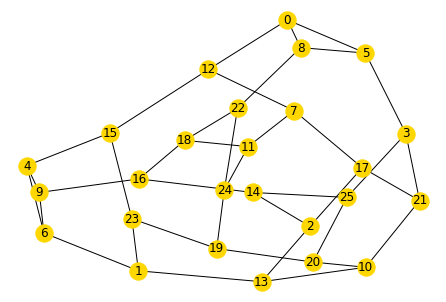

In [24]:
G = nx.generators.random_graphs.random_regular_graph(3, 26)
qubit_num = G.number_of_nodes()
nx.draw_spring(G, with_labels=True, node_color='gold')

Partition: ({1, 2, 4, 6, 7, 9, 10, 12, 13, 15, 17, 21, 23}, {0, 3, 5, 8, 11, 14, 16, 18, 19, 20, 22, 24, 25})
rand idx = 0
cur cut nodes = [2, 7, 9, 10, 12, 21, 23]
Node 2 has cost: 1
Node 7 has cost: 1
Node 9 has cost: 1
Node 10 has cost: 1
Node 12 has cost: 1
Node 21 has cost: 1
Node 23 has cost: 1
Valid hot nodes: [2, 7, 9, 10, 12, 21, 23]
Shuffled valid hot nodes: [12, 9, 23, 2, 7, 10, 21]
Node 12 has cost 1, cur_cost = 0
Node 9 has cost 1, cur_cost = 1
Cut edges: [(9, 16), (7, 11), (12, 0), (23, 19), (2, 14), (20, 10), (3, 21)]
Cut nodes: [9, 16, 7, 11, 12, 0, 23, 19, 2, 14, 20, 10, 3, 21] Hot nodes: [12, 9]


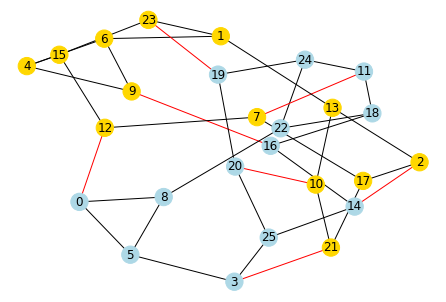

In [25]:
init_state = '0'*len(G.nodes)
partition = kernighan_lin_bisection(G)
print('Partition:', partition)
subgraphs, cut_edges = graph_funcs.get_subgraphs(G, partition)
cut_nodes, hot_nodes = cutting_funcs.simple_choose_nodes(G, subgraphs, cut_edges, max_cuts=2, init_state=init_state)
print('Cut edges:', cut_edges)
print('Cut nodes:', cut_nodes, 'Hot nodes:', hot_nodes)
graph_funcs.view_partition(partition, G)

In [61]:
nq = len(G.nodes())
P = 1
shots = 500000
#init_state = '0'*nq
print('Initial state:', init_state)

num_params = P * (nq + 1)

mixer_order = list(np.random.permutation(list(G.nodes)))
print('mixer order:', mixer_order)
print()

Initial state: 00000000000000000000000000
mixer order: [18, 20, 11, 5, 13, 16, 24, 1, 9, 0, 3, 22, 10, 15, 8, 6, 23, 17, 21, 7, 14, 12, 25, 19, 4, 2]



In [62]:
circuit, cuts, fragments, wire_path_map = get_circuit_and_cuts(num_params, init_state, mixer_order)
print('Cuts:', cuts)
print('Fragments:', fragments)
print('Cut circuit into {} fragments with {}-qubits'.format(len(fragments), [f.num_qubits for f in fragments]))
#print('wire path map:', wire_path_map)
for i, f in enumerate(fragments):
    print('Fragment:', i)
    print(f.draw(fold=120))

params: [Parameter(var_0), Parameter(var_1), Parameter(var_2), Parameter(var_3), Parameter(var_4), Parameter(var_5), Parameter(var_6), Parameter(var_7), Parameter(var_8), Parameter(var_9), Parameter(var_10), Parameter(var_11), Parameter(var_12), Parameter(var_13), Parameter(var_14), Parameter(var_15), Parameter(var_16), Parameter(var_17), Parameter(var_18), Parameter(var_19), Parameter(var_20), Parameter(var_21), Parameter(var_22), Parameter(var_23), Parameter(var_24), Parameter(var_25), Parameter(var_26)]
Parameters:
	alpha_0: [Parameter(var_0), Parameter(var_1), Parameter(var_2), Parameter(var_3), Parameter(var_4), Parameter(var_5), Parameter(var_6), Parameter(var_7), Parameter(var_8), Parameter(var_9), Parameter(var_10), Parameter(var_11), Parameter(var_12), Parameter(var_13), Parameter(var_14), Parameter(var_15), Parameter(var_16), Parameter(var_17), Parameter(var_18), Parameter(var_19), Parameter(var_20), Parameter(var_21), Parameter(var_22), Parameter(var_23), Parameter(var_24), 

In [57]:
frag_shots = shots // qmm.fragment_variants(wire_path_map)
print(frag_shots)
init_params = np.arange(1, num_params+1)
backend = qiskit.Aer.get_backend('qasm_simulator')
start = time.time()
recombined_dist = get_circuit_output(init_params, fragments, wire_path_map, frag_shots)
end = time.time()
print('Recombination took {:.3f} seconds, len(recombined_dist) = {}'.format(end-start, len(recombined_dist)))

full_circuit = bind(circuit, init_params)
full_circuit.measure_all()
start = time.time()
result = qiskit.execute(full_circuit, backend=backend, shots=shots).result()
end = time.time()
counts = result.get_counts(full_circuit)
exact_dist = {key : val / shots for key, val in counts.items()}
#print()
#print(exact_dist)
print('Qiskit simulation of full {}-qubit circuit took {:.3f} seconds'.format(full_circuit.num_qubits, end-start))

print(qiskit.quantum_info.hellinger_fidelity(recombined_dist, exact_dist))

250000
	Model time: 9.817, Recombine time: 0.112
Recombination took 10.038 seconds, len(recombined_dist) = 884
Qiskit simulation of full 28-qubit circuit took 28.187 seconds
0.9363320168953324


## Test repeated partitions of the graph

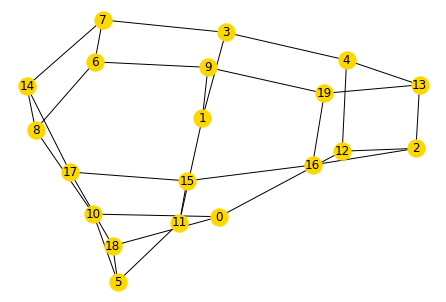

In [26]:
G = nx.generators.random_graphs.random_regular_graph(3, 20)
qubit_num = G.number_of_nodes()
nx.draw_spring(G, with_labels=True, node_color='gold')

In [29]:
init_state = '0'*len(G.nodes)
out = dqva.solve_mis_cut_dqva(init_state, G, m=1, verbose=1, shots=50000, max_cuts=2)

kl bisection: ({1, 3, 4, 6, 7, 8, 9, 13, 14, 19}, {0, 2, 5, 10, 11, 12, 15, 16, 17, 18})
rand idx = 0
cur cut nodes = [1, 4, 8, 13, 14, 19]
Node 1 has cost: 1
Node 4 has cost: 1
Node 8 has cost: 1
Node 13 has cost: 1
Node 14 has cost: 1
Node 19 has cost: 1
Valid hot nodes: [1, 4, 8, 13, 14, 19]
Shuffled valid hot nodes: [1, 19, 14, 8, 4, 13]
Node 1 has cost 1, cur_cost = 0
Node 19 has cost 1, cur_cost = 1
Start round 1.1, Initial state = 00000000000000000000
	Num params = 41
	Current Mixer Order: [15, 18, 6, 11, 9, 19, 13, 3, 2, 7, 8, 17, 14, 12, 10, 16, 4, 5, 0, 1]
Parameters:
	alpha_0: [Parameter(var_0), Parameter(var_1), Parameter(var_2), Parameter(var_3), Parameter(var_4), Parameter(var_5), Parameter(var_6), Parameter(var_7), Parameter(var_8), Parameter(var_9), Parameter(var_10), Parameter(var_11), Parameter(var_12), Parameter(var_13), Parameter(var_14), Parameter(var_15), Parameter(var_16), Parameter(var_17), Parameter(var_18), Parameter(var_19)]
	gamma_0: var_20
	alpha_1: [Parame

TypeError: descriptor 'union' of 'set' object needs an argument